# Trend is not Dead

Diego Alvarez diego.alvarez@colorado.edu

# Packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

# Collect Data & Prep Data

In [2]:
try:
    
    df = pd.read_parquet(
        path = "futures.parquet",
        engine = "pyarrow")
    
except: 
    
    tickers = pd.read_csv("tickers.csv")["Symbol"].dropna().drop_duplicates().to_list()
    
    start_date = dt.date(year = 1980, month = 1, day = 1)
    end_date = dt.date.today()
    
    df = (yf.download(
        tickers = tickers, start = start_date, end = end_date)[
        "Adj Close"].
        reset_index().
        melt(id_vars = "Date").
        dropna())
    
    df.to_parquet(
        path = "futures.parquet",
        engine = "pyarrow")

In [3]:
def _get_stats(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            rtn = lambda x: x.value.pct_change(),
            ma10  = lambda x: x.value.rolling(window = 10).mean(),
            ma100 = lambda x: x.value.rolling(window = 100).mean(),
            signal = lambda x: np.where(x.ma10 > x.ma100, 1, -1)))

In [4]:
df_stats = (df.groupby(
    "variable", group_keys = True).
    apply(_get_stats).
    dropna())

# Calculate lag and plot

In [5]:
def _shift(df: pd.DataFrame, shift_val: int = 1):
    return(df.assign(
        shifted_signal = lambda x: x.signal.shift(shift_val)))
 
df_shifted = (df_stats[
    ["Date", "variable", "rtn", "signal"]].
    groupby("variable", group_keys = True).
    apply(_shift).
    reset_index(drop = True).
    dropna())

In [6]:
df_rtn = (df_shifted.assign(
    lag0_rtn = lambda x: x.rtn * x.signal,
    lag1_rtn = lambda x: x.rtn * x.shifted_signal,
    spread = lambda x: x.lag1_rtn - x.lag0_rtn).
    query("variable != ['ES=F', 'MGC=F']"))

In [7]:
df_rtn_wider = (df_rtn[
    ["Date", "variable", "spread"]].
    pivot(index = "Date", columns = "variable", values = "spread"))

df_cum_wider = np.cumprod(1 + df_rtn_wider) - 1
df_cum_wider_avg = df_cum_wider.mean(axis = 1)

In [8]:
df_signal_rtn = (df_rtn[
    ["Date", "variable", "lag0_rtn", "lag1_rtn"]].
    pivot(index = "Date", columns = ["variable"], values = ["lag0_rtn", "lag1_rtn"]))

df_signal_cum = np.cumprod(1 + df_signal_rtn) - 1

df_cum_spread = (df_signal_cum.reset_index().melt(
    id_vars = "Date").
    rename(columns = {None: "lag"}).
    pivot(index = ["Date", "variable"], columns = "lag", values = "value").
    reset_index().
    dropna().
    assign(spread = lambda x: x.lag1_rtn - x.lag0_rtn)
    [["Date", "variable", "spread"]].
    pivot(index = "Date", columns = "variable", values = "spread"))

df_cum_spread_avg = df_cum_spread.mean(axis = 1)

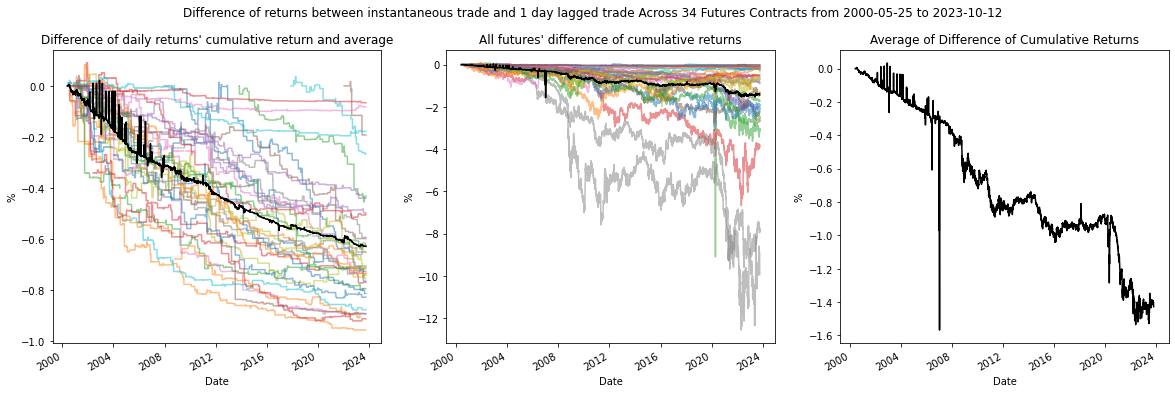

In [9]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

df_cum_wider.plot(
    alpha = 0.5,
    legend = False,
    ax = axes[0])

df_cum_wider_avg.plot(
    color = "black",
    ax = axes[0],
    ylabel = "%",
    title = "Difference of daily returns' cumulative return and average")

df_cum_spread.plot(
    alpha = 0.5,
    ax = axes[1],
    legend = False,
    ylabel = "%",
    title = "All futures' difference of cumulative returns")

df_cum_spread_avg.plot(
    ax = axes[1],
    color = "black",
    ylabel = "%")

df_cum_spread_avg.plot(
    ax = axes[2],
    color = "black",
    ylabel = "%",
    title = "Average of Difference of Cumulative Returns")

fig.suptitle("Difference of returns between instantaneous trade and 1 day lagged trade Across {} Futures Contracts from {} to {}".format(
    len(df_rtn_wider.columns.to_list()),
    df_rtn_wider.index.min().date(),
    df_rtn_wider.index.max().date()))

plt.show()

Let's do some cleaning of the values

In [10]:
def _roll_z_score(df: pd.DataFrame, window: int = 30, z_score_cutoff: float = 2) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            roll_mean = lambda x: x.avg.rolling(window = window).mean(),
            roll_std = lambda x: x.avg.rolling(window = window).std(),
            z_score = lambda x: np.abs((x.avg - x.roll_mean) / x.roll_std),
            replace_value = lambda x: np.where(x.z_score > z_score_cutoff, x.roll_mean, x.avg)))

df_avg = (df_cum_spread_avg.to_frame().rename(
    columns = {0: "diff_avg_cum"}).
    reset_index().
    merge(
        right = df_cum_wider_avg.reset_index().rename(columns = {0:"diff_cum_avg"}),
        how = "inner",
        on = ["Date"]).
    melt(id_vars = "Date", value_name = "avg"))

df_z_score = (df_avg.groupby(
    "variable", group_keys = False).
    apply(_roll_z_score))

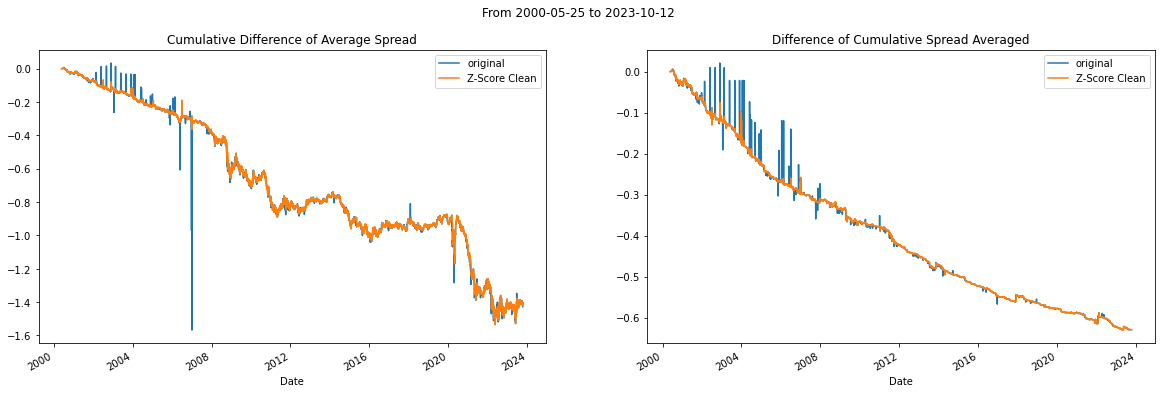

In [11]:
cols = df_z_score.variable.drop_duplicates().to_list()
col_renamer = {
    "diff_avg_cum": "Cumulative Difference of Average Spread",
    "diff_cum_avg": "Difference of Cumulative Spread Averaged"}

fig, axes = plt.subplots(ncols = len(cols), figsize = (20,6))

for i, col in enumerate(cols):
    
    df_plot = (df_z_score.query(
        "variable == @col").
        drop(columns = ["roll_mean", "roll_std", "z_score", "variable"]).
        set_index("Date").
        rename(columns = {
            "avg": "original",
            "replace_value": "Z-Score Clean"}))

    (df_plot.plot(
        ax = axes[i],
        title = col_renamer[col]))
    
fig.suptitle("From {} to {}".format(
    df_plot.index.min().date(),
    df_plot.index.max().date()))
plt.show()

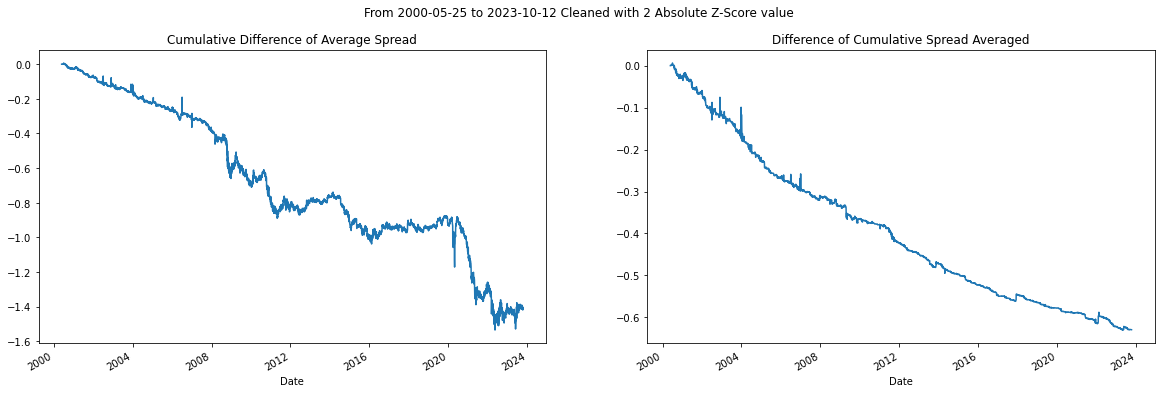

In [12]:
cols = df_z_score.variable.drop_duplicates().to_list()
col_renamer = {
    "diff_avg_cum": "Cumulative Difference of Average Spread",
    "diff_cum_avg": "Difference of Cumulative Spread Averaged"}

fig, axes = plt.subplots(ncols = len(cols), figsize = (20,6))

for i, col in enumerate(cols):
    

    (df_z_score[
        ["Date", "variable", "replace_value"]].
        query("variable == @col").
        pivot(index = "Date", columns = "variable", values = "replace_value").
        plot(
            ax = axes[i],
            legend = False,
            title = col_renamer[col]))
    
fig.suptitle("From {} to {} Cleaned with 2 Absolute Z-Score value".format(
    df_plot.index.min().date(),
    df_plot.index.max().date()))
plt.show()

# Calculate Signal to market returns

In [128]:
def _get_rtns(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            rtn = lambda x: x.price.pct_change(),
            vol = lambda x: x.rtn.rolling(window = 30).std() * np.sqrt(252)).
        dropna())

df_cta = (df_stats[
    ["Date", "variable", "value", "signal"]].
    rename(columns = {"value": "price"}).
    pivot(index = "Date", columns = "variable", values = ["price", "signal"]).
    resample("Q").
    first().
    reset_index().
    melt(id_vars = "Date", var_name = ["stat", "variable"]).
    dropna().
    pivot(index = ["Date", "variable"], columns = "stat", values = "value").
    reset_index().
    groupby("variable").
    apply(_get_rtns).
    reset_index(drop = True).
    assign(
        cta_rtn = lambda x: x.rtn * x.signal,
        cta_rr = lambda x: x.cta_rtn / x.vol))

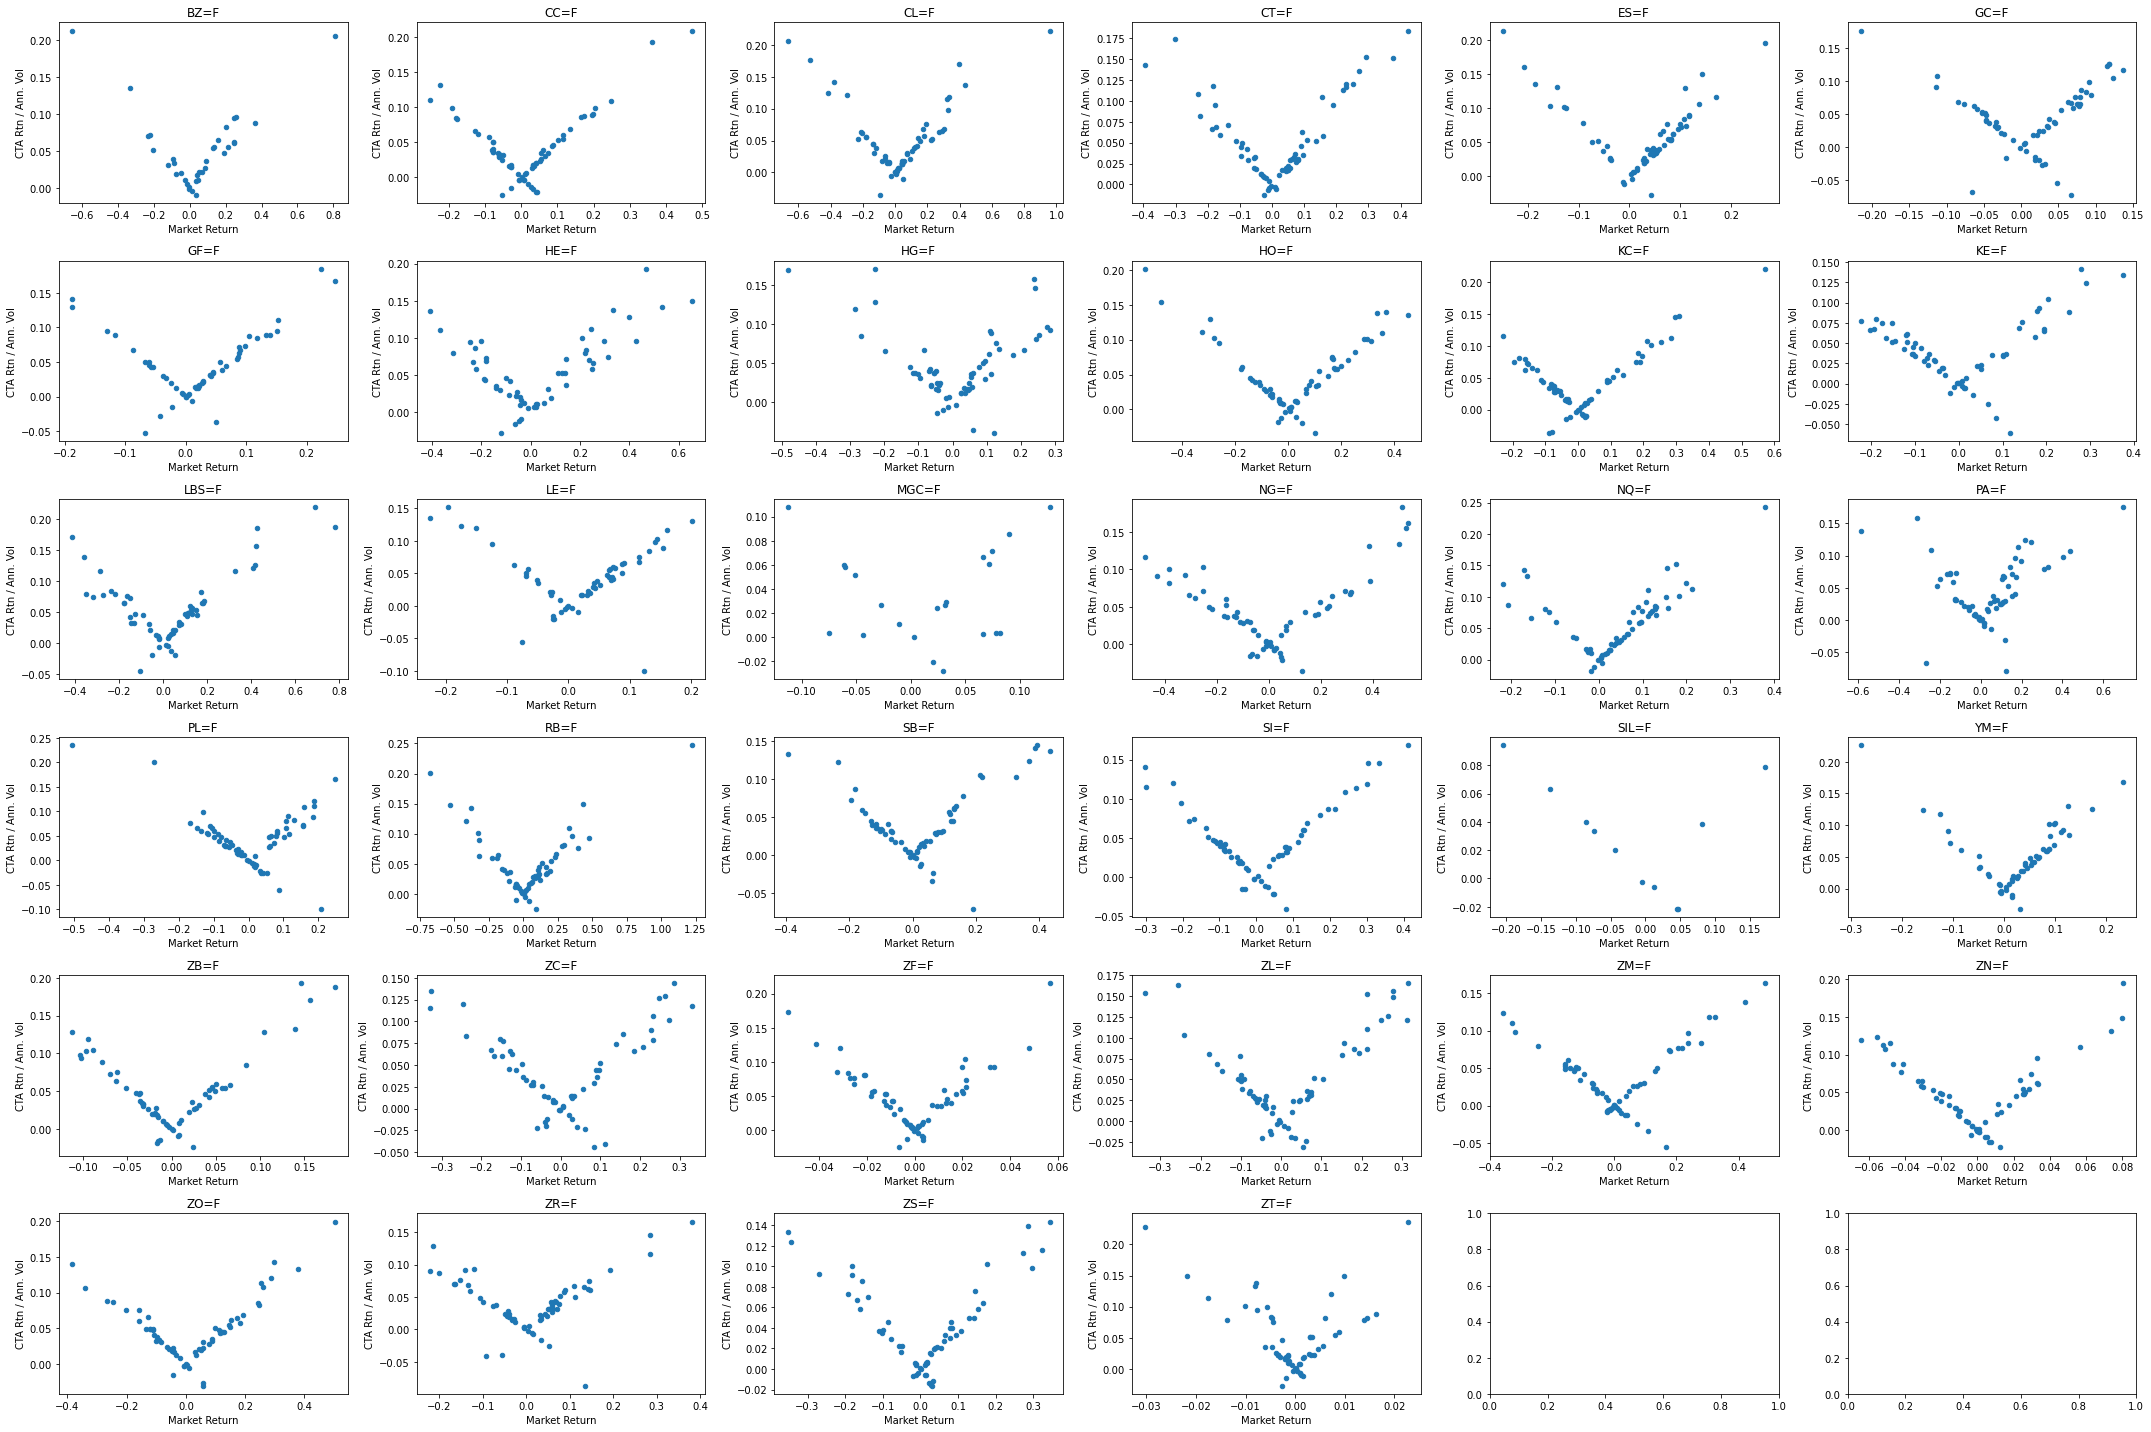

In [131]:
tickers = df_cta.variable.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 6, nrows = 6, figsize = (30,20))

counter = 0
for i in range(6):
    for j in range(6):
        
        try:
        
            ticker = tickers[counter]

            (df_cta.query(
                "variable == @ticker").
                plot(
                    kind = "scatter",
                    x = "rtn", y = "cta_rr",
                    ax = axes[i,j],
                    title = ticker,
                    ylabel = "CTA Rtn / Ann. Vol",
                    xlabel = "Market Return"))

            counter += 1
            
        except: pass
        
        
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Combined Quarterly CTA Return vs. Market Return\n 34 Contracts from 2007-12-31 to 2023-12-31'}, xlabel='rtn', ylabel='cta_rr'>

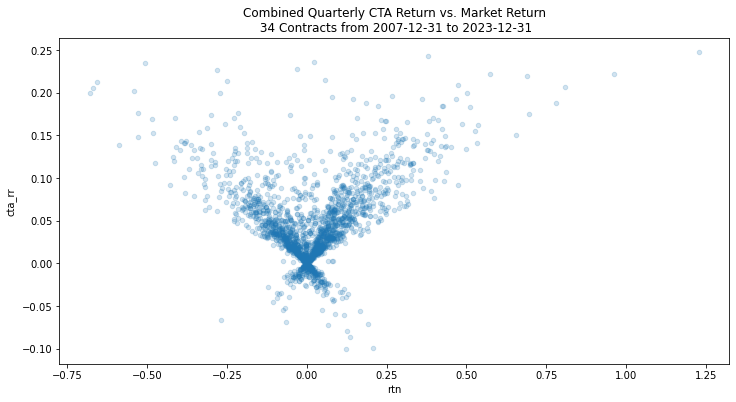

In [135]:
(df_cta.plot(
    kind = "scatter",
    alpha = 0.2,
    figsize = (12,6),
    x = "rtn", y = "cta_rr",
    title = "Combined Quarterly CTA Return vs. Market Return\n {} Contracts from {} to {}".format(
        len(df_cta.variable.drop_duplicates().to_list()),
        df_cta.Date.min().date(),
        df_cta.Date.max().date())))

Since I don't have high quality data going before 2008 I'm not able to do the pre-08 and post-08 analysis.